# NBA Tournament


## Table of Contents

- Introduction
- Data: Collection, Cleaning and Preprocessing
- Machine Learning
- NBA Tournament
- Conclusion


### Introduction

This project stems from a [ proposed project ] developed for a Machine Learning course, using Supervised Learning. I will attempt to gain better results and try out different models to establish a well defined tournament.
Previously, I used features intented to aid in winning a game such as Block, Steal, Rebound, etc. Logistic and linear regression were the only models used to make these winning prediction. <br/>
For this project, I will add more features and experiment with more regression models while using a more and advanced data to create an efficient model to predict the winner of team match ups, using data extracted from [NBA Site](https://www.nba.com)

<font color=red>Note:</font> [Selenium](https://selenium-python.readthedocs.io/installation.html) was used to retreive the source data. <br/>
This notebook contains interactive graphs which may require you to install a few dependencies. Graph images are displayed below the respected cell to view without running the program.


### Data


#### Collection [Selenium]

Below is the Selenium code used to retreive the our listings
Here we are going to extract the basketball seasons from the [NBA Site](https://www.nba.com/stats/teams/boxscores-traditional)


In [1]:
# Importing all neccesary packages
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import ElementClickInterceptedException as ECIE, NoSuchElementException as NSEE, StaleElementReferenceException as SERE, TimeoutException as TE, ElementNotInteractableException as ENIE

from openpyxl import Workbook, load_workbook
from buckets import dimes
import time
import re

In [4]:
import pandas as pd
import numpy as np
import random

##### Table Collection & Organization


In [ ]:
# Webdriver: Chrome | Site: NBA site

driver = webdriver.Chrome()
# url = "https://www.nba.com/stats/teams/boxscores-traditional"
# driver.get(url)


In [ ]:
# Create an Excel to begin data transfer
wb = Workbook()
wb.save('nba_box_scores.xlsx')
ws = wb.active
dfs = []

In [ ]:
# Dictionary created from NBA Glossary
driver.execute_script("window.scrollTo(0,300)")

glossary_bttn = WebDriverWait(driver, 10).until(EC.element_to_be_clickable(driver.find_element(By.CLASS_NAME, "Crom_cromGlossary__ZHrZf")))
glossary_bttn.click() # View Glossary

abbr_list = {}

abbrs = driver.find_elements(By.CLASS_NAME, "StatsTableGlossary_dt__GPooh") # Abbr
defs = driver.find_elements(By.CLASS_NAME, "StatsTableGlossary_dd__zcr38") # defs

for idx, ab in enumerate(abbrs):
    abbr_list[ab.text] = defs[idx].text

glossary_bttn.click() # Close Glossary


In [ ]:
# Capture all seasons in the list from web page
season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
seasons_arr = [sn.text for sn in season_drpdwn.options]
xpath_table = dimes.get('XPATH_TABLE')

In [ ]:
# Ensure table is retrieved from 'Regular Season' Games
ssn_type_drpdwn = driver.find_element(By.XPATH,'//*[@id="__next"]/div[2]/div[2]/div[3]/section[1]/div/div/div[2]/label/div')
ssn_type = Select(driver.find_element(By.XPATH, '//*[@id="__next"]/div[2]/div[2]/div[3]/section[1]/div/div/div[2]/label/div/select'))
ssn_type.select_by_visible_text("Regular Season")


In [ ]:
# Extact, Manipulate and Insert Seasons' table into  Excel

def assign_names(matches, teams, sn, df):
        
    print(f'Made it in for Season: {sn} with shape {df.shape}')

    # print(len(matches), '\n', len(teams), '\n', sn, '\n', df.shape) 
    team_names = []
    opp_names = []
    opp_abbrs = []

    # Assign names to team and opponent Series respectfully
    for i,match in enumerate(matches):

        team_abbr = re.split((r'vs. | @'),match)[0].rstrip()
        opp_abbr = re.split((r'vs. | @'),match)[1].lstrip()

        if team_abbr in teams:
            team_names.append(teams[team_abbr])
        if opp_abbr in teams:
            opp_names.append(teams[opp_abbr])
            opp_abbrs.append(opp_abbr)    

    df.insert(1, 'TEAM', team_names)
    df.insert(2, 'OPP ABBR', opp_abbrs)
    df.insert(3, 'OPPONENT', opp_names)
    df.insert(4, "SEASON", sn)
    
    team_names.clear()
    opp_abbrs.clear()
    opp_names.clear()

    
    return df


In [ ]:
# Driver Code

xpath_pages = dimes.get('XPATH_PAGES')
teams = {}

for i, sn in enumerate(seasons_arr):


    try:

        ad = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()
        cookie = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[3]/div[2]/div/div[1]/div/div[2]/div/button'))).click()

        season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
        season_drpdwn.select_by_visible_text(sn)
        print(sn)

        page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
        time.sleep(2)

        pages = Select(driver.find_element(By.XPATH, xpath_pages))
        pages.select_by_visible_text("All")

    except:

        season_drpdwn = Select(driver.find_element(By.CLASS_NAME,"DropDown_select__4pIg9"))
        season_drpdwn.select_by_visible_text(sn)
        print(sn)

        page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
        time.sleep(2)

        pages = Select(driver.find_element(By.XPATH, xpath_pages))
        pages.select_by_visible_text("All")
        time.sleep(2)

    table = WebDriverWait(driver, 10).until(EC.visibility_of_element_located((By.XPATH, xpath_table))).get_attribute("outerHTML")
    sub_df = pd.read_html(table)[0]
    sub_df.dropna(how='all', axis=1, inplace=True)
    sub_df = sub_df.rename(columns={'TEAM': 'TEAM ABBR'})    
    all_teams = sub_df['TEAM ABBR'].unique()

    matches = sub_df['MATCH UP']
    
    print(f'Number of Teams this Season: {len(all_teams)}')
    # print(sub_df)

    if all(ele in teams for ele in all_teams): # Assign existing names to Abbreviations

        new_df = assign_names(matches, teams, sn, sub_df)
        dfs.append(new_df)

        # Append each Season's table into Excel file
        with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            new_df.to_excel(writer, sheet_name= sn, index=False, header=True)
    
    else:
        # Get all names missing from the teams list
        # Handle all possible exceptions 
        
        missing_teams = [t for t in all_teams if t not in teams]
        print(missing_teams)
        for team in missing_teams:
        
            try:
                if team == 'ORL':
                    teams[team] = 'ORLANDO MAGIC'
                else:
                    linked_text = WebDriverWait(driver,2).until(EC.presence_of_element_located((By.LINK_TEXT, team)))
                    linked_text.click()
                    teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                    driver.execute_script("window.history.go(-1)") # go back a page
                    time.sleep(2)
                print(f'{team} Cleared!')
        

            except ECIE: # Overlay may be blocking focused elements
                print('Entered ECIE: Element Click Intercepted Exception')
                print(f'Nope!! Trying to capture {team} again')
                ad = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()
                cookie = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH, '/html/body/div[3]/div[2]/div/div[1]/div/div[2]/div/button'))).click()


                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

            except NSEE: # Element doesn't exist. 
                print('Entered NSSE: No Such Element Exception')
                time.sleep(1)
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')
            
            except TE: 
                print('Entered TE: Timeout Exception')
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                print(f'Trying to capture {team} again')

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')
                continue

            except SERE:
                print('Entered SERE: Stale Element Reference Exception')

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(2)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

            except ENIE:
                print('Entered ENIE: Element Not Interactable Exception')
                ad = WebDriverWait(driver,20).until(EC.presence_of_element_located((By.CLASS_NAME, 'bx-close-xsvg'))).click()

                page_drpdown = driver.find_element(By.CLASS_NAME, "Pagination_pageDropdown__KgjBU")
                time.sleep(1.5)

                pages = Select(driver.find_element(By.XPATH, xpath_pages))
                pages.select_by_visible_text("All")

                driver.find_element(By.LINK_TEXT, team).click()
                teams[team] = (driver.find_element(By.CLASS_NAME, 'TeamHeader_name__MmHlP').text).replace('\n','')
                driver.execute_script("window.history.go(-1)") # go back a page
                time.sleep(2)
                print(f'{team} Cleared!')

        new_df = assign_names(matches, teams, sn, sub_df)
        dfs.append(new_df)

        with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
            new_df.to_excel(writer, sheet_name= sn, index=False, header=True)
        


In [ ]:
# Combine all tables for DataFrame
df = pd.concat([x for x in dfs], ignore_index=True)

##### url for REGION feature.


In [12]:
# Selenium part

url2 = 'https://www.nba.com/stats/teams'
driver.get(url2)

region_list = driver.find_elements(By.CLASS_NAME, 'StatsTeamsList_division__ZUezr')

In [13]:
# Assigning to REGION df
group = []

# Region: Atlantic, Central, Southeast, Northwest, Pacific, Southwest
for region in region_list:
    rgn = region.text.split('\n')
    group.append(rgn)

region_headers = [rh.pop(0) for rh in group]
group = np.array(group).T # Transpose
group = np.char.upper(group) # Turn all into CAPS

region_df = pd.DataFrame(
    data = group,
    columns=region_headers
)

region_df.to_csv('nba_regions.csv', index=False)

##### url for CONFERENCE feature.


In [14]:
# Selenium part

url3 = 'https://www.nba.com/standings'
driver.get(url3)
confs = driver.find_elements(By.CLASS_NAME, 'Crom_base__f0niE')
division = driver.find_elements(By.CLASS_NAME, 'Crom_caption__Yv_rH')

In [ ]:
# Assigning to CONF. df
dvsn = [] 
conf_groups = []

for conf in confs: # East | West Confs
    dvsn.append(re.split(r'\n',conf.text)[0].upper())
    lists = re.split(r'\n',conf.text)
    c_names = []

    for idx,each in enumerate(lists):
    
        if re.search(r'^\d{1,2}$',each) != None:
            joint_tn = ''.join([lists[idx+1], lists[idx+2]]).upper()
            # print(joint_tn)
            c_names.append(joint_tn)

    conf_groups.append(c_names)

conf_groups = np.array(conf_groups).T



conf_df = pd.DataFrame(
    data=conf_groups,
    columns= dvsn
)

conf_df.to_csv('nba_standing.csv', index=False)

In [ ]:
# Append Region and Conference to established DataFrame

sides = [] # Conference list
areas = [] # Region list

for each in df['TEAM']:   

	# Handle Conference Column
	for col in conf_df:
		if each in conf_df[col].values:
			sides.append(col.split(" ")[0]) # Apply 'EASTERN' | 'WESTERN'

	# Handle Region Column
	for col in region_df:
		if each in region_df[col].values:
			areas.append(col)


df['CONFERENCE'] = sides

# Special Case: Filters the sub df with NOP  in SEASON < 2004-05 and mark it EASTERN CONFERENCE  
# Since this created 2 seperate conference for NOP, it would make the Conferences unbalanced; Keep as WESTERN
# df.loc[(df['SEASON'] < '2004-05') & (df['TEAM'] == 'NEW ORLEANS PELICANS'), 'CONFERENCE'] = 'EASTERN'


for each in df['TEAM']:
	for col in region_df:
		if each in region_df[col].values:
			areas.append(col)




df['REGION'] = areas

In [ ]:
# Export df to Files

with pd.ExcelWriter(path='nba_box_scores.xlsx', engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    df.to_excel(writer, sheet_name= 'Sheet', index=False, header=True)

df.to_csv('nba_box_scores.csv', index=False)

In [ ]:

# Close all opened files and systems
wb.close()
driver.close()

#### Cleaning & Processing

Now we're going to:

- Read data from previously exported csv file
- Normalize the data to condense the distribution
- Update Team Abbreviations to its' lastest of today


In [5]:
# Read data
full_df = pd.read_csv('nba_box_scores.csv')

In [ ]:
# Uncoment and run below if notebook did not run
# df.loc[(df['SEASON'] < '2004-05') & (df['TEAM'] == 'NEW ORLEANS PELICANS'), 'CONFERENCE'] = 'WESTERN'


In [181]:
full_df

,TEAM ABBR,TEAM,OPP ABBR,OPPONENT,SEASON,MATCH UP,GAME DATE,W/L,MIN,PTS,...,DREB,REB,AST,TOV,STL,BLK,PF,+/-,CONFERENCE,REGION
0,NYK,NEW YORK KNICKS,CHI,CHICAGO BULLS,2023-24,NYK vs. CHI,4/14/24,W,53,120,...,37,53,27,21.0,7,6,17,1.0,EASTERN,ATLANTIC
1,CHA,CHARLOTTE HORNETS,CLE,CLEVELAND CAVALIERS,2023-24,CHA @ CLE,4/14/24,W,48,120,...,37,47,36,10.0,10,9,11,10.0,EASTERN,SOUTHEAST
2,POR,PORTLAND TRAIL BLAZERS,SAC,SACRAMENTO KINGS,2023-24,POR @ SAC,4/14/24,L,48,82,...,31,54,18,18.0,11,2,19,-39.0,WESTERN,NORTHWEST
3,HOU,HOUSTON ROCKETS,LAC,LA CLIPPERS,2023-24,HOU @ LAC,4/14/24,W,48,116,...,42,59,31,18.0,7,8,13,11.0,WESTERN,SOUTHWEST
4,MIL,MILWAUKEE BUCKS,ORL,ORLANDO MAGIC,2023-24,MIL @ ORL,4/14/24,L,48,88,...,27,34,16,17.0,10,4,18,-25.0,EASTERN,CENTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66167,PHI,PHILADELPHIA 76ERS,MIL,MILWAUKEE BUCKS,1996-97,PHI vs. MIL,11/1/96,L,48,103,...,26,40,25,14.0,6,4,29,-8.0,EASTERN,ATLANTIC
66168,UTA,UTAH JAZZ,SEA,OKLAHOMA CITY THUNDER,1996-97,UTA vs. SEA,11/1/96,W,48,99,...,32,43,26,9.0,7,6,27,8.0,WESTERN,NORTHWEST
66169,NYK,NEW YORK KNICKS,TOR,TORONTO RAPTORS,1996-97,NYK @ TOR,11/1/96,W,48,107,...,33,44,23,24.0,15,5,29,8.0,EASTERN,ATLANTIC
66170,SEA,OKLAHOMA CITY THUNDER,UTA,UTAH JAZZ,1996-97,SEA @ UTA,11/1/96,L,48,91,...,34,46,16,12.0,6,6,26,-8.0,WESTERN,NORTHWEST


In [6]:
# Prepare name changes
old_abbrs = [['NOH','NOK'], 'VAN', 'CHH', 'SEA', 'NJN' ]
new_abbrs = ['NOP', 'MEM', 'CHA', 'OKC', 'BKN']

for idx,abbr in enumerate(old_abbrs):
    full_df = full_df.replace(abbr,new_abbrs[idx])

team_abbr = full_df['TEAM ABBR'].unique()
team_name = full_df['TEAM']
teams = {}

# Recreate teams Dictionary
for each in team_abbr:
    
    indicies = list(np.where(full_df['TEAM ABBR'] == each))[0]
    teams[each] = full_df['TEAM'].iloc[indicies[0]]    


In [7]:
#Remove after project is completed
full_df.loc[(full_df['SEASON'] < '2004-05') & (full_df['TEAM'] == 'NEW ORLEANS PELICANS'), 'CONFERENCE'] = 'WESTERN'


##### Statistics Below


In [184]:
print(f"Size of Dataframe {full_df.shape}")


Size of Dataframe (66172, 30)


In [8]:
# Sorted Team List for easier read
from collections import OrderedDict

sorted_teamsDict = OrderedDict(sorted(teams.items()))

distinct_teams = sorted(full_df['TEAM'].unique())
wins = []
losses = []
total = []
win_rate = []

for each in sorted_teamsDict:

    win = sum(full_df[full_df['TEAM ABBR'] == each]['W/L'] == 'W') # CHANGE back to W
    loss = sum(full_df[full_df['TEAM ABBR'] == each]['W/L'] == 'L') # CHANGE  back to L
    wins.append(win)
    losses.append(loss)
    total.append(win+loss)
    win_rate.append(round(win/(win+loss),2))

bar_chart_df = pd.DataFrame(data={'WINS':wins, 'LOSSES':losses, 'TOTAL': total, 'WIN RATE':win_rate}, index=sorted_teamsDict.values())

In [ ]:
# Bar Chart of Results from SEASONS 1996-2024
bar_chart_df

In [13]:
# Bar Chart of Wins and Losses
from plotly import express as px

fig = px.bar(bar_chart_df, x= bar_chart_df.index, y= ['LOSSES','WINS'], barmode = 'stack', text_auto = True,
             height=400)

fig.update_layout(
    title= 'Wins & Losses of Teams [1996-2024]',
    xaxis_title='Team',
    yaxis_title='Total Games Played',
    legend_title='Result',
)
fig.show()



In [11]:
# Bar Chart of Overall Winning Rate
fig1 = px.bar(bar_chart_df, x= bar_chart_df.index, y='WIN RATE')

fig1.update_layout(
    title= 'Teams\' Historical Performance',
    xaxis_title='Team',
    yaxis_title='Win Rate',
)
fig1.show()

In [10]:
# Condense the distribution [Normalzation]

from sklearn.preprocessing import LabelEncoder, MinMaxScaler

encoder = LabelEncoder()
scalar = MinMaxScaler()

full_df["W/L"] = encoder.fit_transform(full_df["W/L"]) # WIN: 1 , LOSE: 0

num_cols = full_df.select_dtypes(include='number')

norm_df = pd.DataFrame(scalar.fit_transform(num_cols), columns = num_cols.columns)
norm_df = pd.concat([full_df.drop(columns=num_cols.columns),norm_df], axis=1)

norm_df = norm_df.sort_values(by=['SEASON']).reset_index(drop=True)


#### Machine Learning

- Splitting data as 80/10/10 train-val-test
- Experiementing DecisionTreeRegressor


In [11]:
# Prepare data for ML
quant_features = norm_df.select_dtypes(['category', 'object'])
qual_features =  norm_df.select_dtypes(['number'])

X = qual_features.drop(columns=['W/L'])
y = qual_features['W/L']

In [29]:
# Decision Tree Regression Model
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor as DTR, DecisionTreeClassifier as DTC



# regression = DTR()
regression = DTC(criterion='gini')

X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.2, random_state=42)

regression.fit(X_train,y_train)
y_pred = regression.predict(X_remain)

feature_importances = regression.feature_importances_




X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, test_size=0.2, random_state=42) # 0.25

regression.fit(X_val,y_val)
y_pred1 = regression.predict(X_test)

print('Train: ', round(regression.score(X_train,y_train), 2))
print('Val: ', round(regression.score(X_val,y_val), 2))
print('Test: ', round(regression.score(X_test,y_test), 2))


Train:  1.0
Val:  1.0
Test:  1.0


In [226]:
# Finding important features in the dataframe
fi_char = pd.DataFrame( {'Events' : X.columns, 'Importance': feature_importances})

In [23]:
# Feature importance graph below
fi_bar = px.bar( fi_char, y= 'Events', x='Importance', orientation='h')

fi_bar.update_layout(
    title= 'Importance of  Each Feature',
    height = 500,
    width = 1000
) 
fi_bar.show()


The above visual shows that one Plus-Minus shows a high relavence to the predicting the target variable. The golden rule of thumb is not to fill your model with a lot of columns as it may lead several issues like overfitting or correlations with one another, where some algorithms doesn't do well with. <br/>

Since there are not a lot of columns used here, we will still add these to the model

1.0
Mean Squared Error of testing set:0.0
              precision    recall  f1-score   support

        loss       1.00      1.00      1.00      1316
         win       1.00      1.00      1.00      1331

    accuracy                           1.00      2647
   macro avg       1.00      1.00      1.00      2647
weighted avg       1.00      1.00      1.00      2647



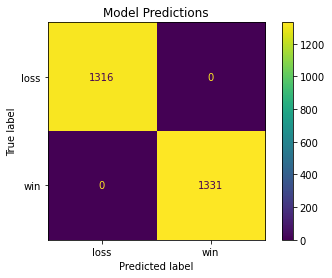

In [30]:
# Model Performance

from sklearn.metrics import mean_squared_error, classification_report, ConfusionMatrixDisplay, accuracy_score
mse = mean_squared_error(y_remain,y_pred) # Gets the average loss between actual and predicted value of the target

print(accuracy_score(y_test,y_pred1))
print(f"Mean Squared Error of testing set:{round(mse,2)}")

print(classification_report(y_test,y_pred1,target_names=['loss','win'] )) # Explained in Markdown Note 3

cm = ConfusionMatrixDisplay.from_predictions(y_test,y_pred1 ,display_labels=['loss','win']) # Explained in Markdown Note 4
cm.ax_.set_title('Model Predictions')
print(cm)

# WORK ON REMAINDER

- Create Team Tournament [Regions & Conferences]
  - Probably add penalty (positive/negative) to the current match up


### Summary

In [31]:

summary_teams = {}
teams_historical = {}

for each in distinct_teams:
    ind_team = full_df[full_df['TEAM'] == each]

    prev_ssn_records = ind_team[(ind_team['SEASON'] == '2022-23')][ind_team.columns[8:28]]
    tie_break_stats = ind_team[(ind_team['SEASON'] <= '2021-22')][ind_team.columns[8:28]]

    ind_team = np.mean(prev_ssn_records, axis=0)
    tie_breaker_sum = np.mean(tie_break_stats, axis=0)

    summary_teams[each] = ind_team
    teams_historical[each] = tie_breaker_sum

# Create the Average for each team from last Season
summary_dict = pd.DataFrame(summary_teams)
teams_his = pd.DataFrame(teams_historical)
# summary_dict = summary_dict.T

### THE GAME

<u>Group play - 30 teams</u>

- All 30 teams are split into 6 groups; "random draw of last season records"
  - 3 groups 5 teams in East, and in West

- Each team in the group plays each other 1 time, totaling 4 games each
  - teams with the best group play record after those 4 games, moves on; 3 on east and 3 on west.

- Team with the next best record in each conference are claimed as the wild card (1 in both conference)


<u>Knockout round - 8 teams</u>

- Single Elimination Match. Each team plays 1 game against a group in conference
  - 4 teams remaining 

<u>Semifinals - 4 teams</u>

- 2 teams from East 2 teams West

<u>Final - 2 teams</u>

- 1 team from East & 1 team from West

In [32]:
east_conf = full_df[full_df['CONFERENCE'] == 'EASTERN']
west_conf = full_df[full_df['CONFERENCE'] == 'WESTERN']

east_teams = list(east_conf['TEAM'].unique())
west_teams = list(west_conf['TEAM'].unique())

In [16]:
# Function to split remainder teams within a Conference

def split_teams(teams, num_groups):

    random.shuffle(teams)
    sub_group = []
    groups = []

    group_size = len(teams) / num_groups
    print(" Group Size: ", group_size)

    for idx,each in enumerate(teams):
        
        if (idx + 1) % group_size != 0:
            sub_group.append(each)
        else:
            sub_group.append(each)
            groups.append(sub_group)
            sub_group = []

    return groups

In [17]:
splitted_east = split_teams(east_teams, 3)
splitted_west = split_teams(west_teams, 3)

 Group Size:  5.0
 Group Size:  5.0


In [230]:
summary_dict

,ATLANTA HAWKS,BOSTON CELTICS,BROOKLYN NETS,CHARLOTTE HORNETS,CHICAGO BULLS,CLEVELAND CAVALIERS,DALLAS MAVERICKS,DENVER NUGGETS,DETROIT PISTONS,GOLDEN STATE WARRIORS,...,OKLAHOMA CITY THUNDER,ORLANDO MAGIC,PHILADELPHIA 76ERS,PHOENIX SUNS,PORTLAND TRAIL BLAZERS,SACRAMENTO KINGS,SAN ANTONIO SPURS,TORONTO RAPTORS,UTAH JAZZ,WASHINGTON WIZARDS
MIN,48.426829,48.731707,48.121951,48.365854,48.548780,48.487805,48.609756,48.182927,48.304878,48.365854,...,48.426829,48.243902,48.487805,48.243902,48.121951,48.365854,48.426829,48.304878,48.304878,48.182927
PTS,118.426829,117.939024,113.353659,110.951220,113.121951,112.256098,114.219512,115.792683,110.304878,118.939024,...,117.475610,111.414634,115.219512,113.646341,113.402439,120.707317,113.036585,112.853659,117.073171,113.158537
FGM,44.609756,42.195122,41.451220,41.280488,42.536585,41.560976,40.036585,43.585366,39.560976,43.146341,...,43.085366,40.524390,40.817073,42.109756,40.451220,43.573171,43.085366,41.878049,42.500000,42.146341
FGA,92.365854,88.756098,85.097561,90.402439,86.780488,85.170732,84.256098,86.439024,87.073171,90.158537,...,92.560976,86.268293,83.780488,90.097561,85.378049,88.195122,92.597561,91.329268,89.817073,86.914634
FG%,48.432927,47.630488,48.848780,45.834146,49.145122,48.951220,47.628049,50.536585,45.476829,47.979268,...,46.658537,47.145122,48.769512,46.809756,47.476829,49.457317,46.741463,45.956098,47.414634,48.689024
3PM,10.756098,16.036585,12.780488,10.743902,10.414634,11.585366,15.195122,11.817073,11.390244,16.621951,...,12.134146,10.768293,12.621951,12.207317,12.878049,13.756098,11.109756,10.731707,13.341463,11.280488
3PA,30.548780,42.585366,33.792683,32.548780,28.865854,31.573171,41.000000,31.207317,32.426829,43.170732,...,34.109756,31.109756,32.621951,32.609756,35.280488,37.317073,32.195122,32.024390,37.792683,31.719512
3P%,35.339024,37.540244,38.013415,32.947561,35.700000,36.631707,37.131707,37.601220,34.787805,38.463415,...,35.689024,34.807317,38.501220,37.131707,36.414634,36.771951,34.648780,33.615854,35.198780,35.423171
FTM,18.451220,17.512195,17.670732,17.646341,17.634146,17.548780,18.951220,16.804878,19.792683,16.024390,...,19.170732,19.597561,20.963415,17.219512,19.621951,19.804878,15.756098,18.365854,18.731707,17.585366
FTA,22.560976,21.573171,22.085366,23.560976,21.804878,22.487805,25.085366,22.365854,25.682927,20.182927,...,23.707317,25.000000,25.097561,21.719512,24.646341,25.060976,21.207317,23.439024,23.841463,22.414634


In [41]:
def the_game(team1, team2):
    
    # print(team1.name,'\n',team2.name)
    comp_stats = pd.concat([team1,team2], axis=1).transpose()
    winner = regression.predict_proba(comp_stats)[0]
    # print("Results: " ,winner)
    

    if all(map(lambda x: x == winner[0], winner)):
        print( random.choices(winner[0],k=1) )
    else:
        print( 'Result: ', winner )

    return 0


In [19]:
def tied_match(team1, team2):
    diff = np.abs(team1 - team2)

    #Rematch "OVERTIME"
    temp1 = team1 + random.uniform(-diff, diff)
    temp2 = team2 + random.uniform(-diff, diff)
    
    # print(temp1)
    the_game(temp1,temp2)

    return

In [45]:
# Prepare teams for matchups
def match_up(conf):
    for gp in conf:
        for i in range(len(gp)):
            for j in range(i+1, len(gp)):
                curr_team = gp[i]
                opp_team = gp[j]

                print(f'{opp_team} is paired with {curr_team}')
                # PLAY THE GAME
                the_game(summary_dict[opp_team], summary_dict[curr_team])
                


match_up(splitted_east)
# match_up(splitted_west)

DETROIT PISTONS is paired with CHARLOTTE HORNETS
Result:  [1. 0.]
CHICAGO BULLS is paired with CHARLOTTE HORNETS
Result:  [0. 1.]
NEW YORK KNICKS is paired with CHARLOTTE HORNETS
Result:  [0. 1.]
ATLANTA HAWKS is paired with CHARLOTTE HORNETS
Result:  [1. 0.]
CHICAGO BULLS is paired with DETROIT PISTONS
Result:  [0. 1.]
NEW YORK KNICKS is paired with DETROIT PISTONS
Result:  [0. 1.]
ATLANTA HAWKS is paired with DETROIT PISTONS
Result:  [1. 0.]
NEW YORK KNICKS is paired with CHICAGO BULLS
Result:  [0. 1.]
ATLANTA HAWKS is paired with CHICAGO BULLS
Result:  [1. 0.]
ATLANTA HAWKS is paired with NEW YORK KNICKS
Result:  [1. 0.]
WASHINGTON WIZARDS is paired with ORLANDO MAGIC
Result:  [1. 0.]
BROOKLYN NETS is paired with ORLANDO MAGIC
Result:  [0. 1.]
MILWAUKEE BUCKS is paired with ORLANDO MAGIC
Result:  [0. 1.]
CLEVELAND CAVALIERS is paired with ORLANDO MAGIC
Result:  [0. 1.]
BROOKLYN NETS is paired with WASHINGTON WIZARDS
Result:  [0. 1.]
MILWAUKEE BUCKS is paired with WASHINGTON WIZARDS


In [ ]:
# FO


winning_teams = norm_df[norm_df['WIN%'] >= win_rate1]

#This is the selected data
data_features = ['Team', 'Season', 'WIN%', 'W/L', 'FG%', '+/-', 'PTS',   'REB', 'STL', 'BLK']
selected_data = winning_teams[data_features]

# Sorting the data by season
selected_data = selected_data.sort_values('Season')
selected_data = selected_data.reset_index(drop=True)
# Predicting winners of matchups
predicted_winner_teamname = None
predicted_winner_season = None

# Iterate over pairs of teams
for i, team1 in selected_data.iterrows():
    for j, team2 in selected_data.iterrows():
        
        # Skip the same team matchups
        if i == j:
            continue

        # Concatenate features of both teams
        matchup_features = pd.concat([team1[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']],
                                      team2[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']]], axis=1)


        # Reshape the input for prediction
        matchup_features = matchup_features.transpose()
    


        # Predict the winner based on the results of the combined features
        winner_index = reg.predict(matchup_features)[0]


In [ ]:

        # Display the results
        if winner_index == 0:
            predicted_winner_teamname = team1['Team']
            predicted_winner_season = team1['Season']
        else:
            predicted_winner_teamname = team2['Team']
            predicted_winner_season = team2['Season']

        print("Matchup:")
        print("Team 1:", team1['Team'], "(", team1['Season'], ")")
        print("Team 2:", team2['Team'], "(", team2['Season'], ")")
        print("Predicted Winner:", predicted_winner_teamname, "(", predicted_winner_season, ")")
        print()


In [ ]:
# Create an empty dictionary
wins_count = {}
predicted_winners_info = {}

for i, team1 in selected_data.iterrows():
    for j, team2 in selected_data.iterrows():
        if i == j:
            continue

        matchup_features = pd.concat([team1[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']],
                                      team2[['WIN%', 'FG%', 'PTS', 'REB', 'STL', 'BLK', '+/-']]], axis=1)

        matchup_features = matchup_features.transpose()

        winner_index = model.predict(matchup_features)[0]

        if winner_index == 0:
            predicted_winner_teamname = team1['Team']
            predicted_winner_season = team1['Season']
        else:
            predicted_winner_teamname = team2['Team']
            predicted_winner_season = team2['Season']

        # Store the name and season of the predicted winner
        predicted_winners_info[predicted_winner_teamname] = predicted_winner_season

        # Increment the number of wins for the predicted winner
        if predicted_winner_teamname in wins_count:
            wins_count[predicted_winner_teamname] += 1
        else:
            wins_count[predicted_winner_teamname] = 1

# Get the team with the most wins in the matchups
most_wins_winner = max(wins_count, key=wins_count.get)
most_wins_count = wins_count[most_wins_winner]

most_wins_winner_season = predicted_winners_info[most_wins_winner]

# Print the results
print("The team with the Most Wins:", most_wins_winner, "(", most_wins_winner_season, ")")
print("They won", most_wins_count, "games")